In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
BATCH_SIZE = 32
SEQUENCE_LENGTH = 30
HIDDEN_LAYER_SIZE = 50
LEARNING_RATE = 5e-6

In [37]:
df_all = pd.read_csv("Data/preprocessed_data.csv")


In [38]:
df_all

,Unnamed: 0,Date,Value,USD (PM),Bitcoin % Change,Gold % Change
0,0,9/11/16,621.65,NaN,NaN,NaN
1,1,9/12/16,609.67,1324.60,-0.019271,NaN
2,2,9/13/16,610.92,1323.65,0.002050,-0.000717
3,3,9/14/16,608.82,1321.75,-0.003437,-0.001435
4,4,9/15/16,610.38,1310.80,0.002562,-0.008284
...,...,...,...,...,...,...
1821,1821,9/6/21,51769.06,1821.60,0.036472,-0.000384
1822,1822,9/7/21,52677.40,1802.15,0.017546,-0.010677
1823,1823,9/8/21,46809.17,1786.00,-0.111399,-0.008962
1824,1824,9/9/21,46078.38,1788.25,-0.015612,0.001260


In [7]:
num_test = len(df_all) // 5


In [8]:
df_data = df_all.drop("Date", axis=1)
# df_train, df_test = train_test_split(df_data, test_size=0.2)
df_train = df_data.iloc[:-num_test, [2]].copy()
df_test = df_data.iloc[-num_test - SEQUENCE_LENGTH:, [2]].copy()
# df_train = df_data.iloc[num_test:, :1].copy()
# df_test = df_data.iloc[:num_test + SEQUENCE_LENGTH:, :1].copy()


In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(df_train)
X_test = sc.transform(df_test)
y_train = df_train[["Bitcoin % Change"]].values
y_test = df_test[["Bitcoin % Change"]].values


In [10]:
class SequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=SEQUENCE_LENGTH):
        # self.features = features
        # self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(y).float().cuda()
        self.X = torch.tensor(X).float().cuda()

    def __len__(self):
        return self.X.shape[0] - self.sequence_length

    def __getitem__(self, i):
        x = self.X[i:(i + self.sequence_length), :]
        y = self.y[i + self.sequence_length, :]
        return x, y


In [11]:
train_dataset = SequenceDataset(
    X_train,
    y_train,
    sequence_length=SEQUENCE_LENGTH
)

test_dataset = SequenceDataset(
    X_test,
    y_test,
    sequence_length=SEQUENCE_LENGTH
)


In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer_size = HIDDEN_LAYER_SIZE
        self.lstm = nn.LSTM(input_size=SEQUENCE_LENGTH,
                            hidden_size=self.hidden_layer_size,
                            num_layers=2,
                            dropout=0.5,
                            batch_first=True)
        # equivalent to Dense in keras
        self.linear1 = nn.Linear(self.hidden_layer_size, self.hidden_layer_size)
        self.linear2 = nn.Linear(self.hidden_layer_size, 1)

        self.dropout = nn.Dropout(0.5)

        self.hidden_cell = (torch.zeros(2, BATCH_SIZE, self.hidden_layer_size).
                            cuda(),
                            torch.zeros(2, BATCH_SIZE, self.hidden_layer_size).cuda())

    def forward(self, input_seq):
        _, (hn, _) = self.lstm(input_seq.view(
            len(input_seq), 1, -1), self.hidden_cell)
        # lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # predictions = self.linear(lstm_out.view(len(input_seq), -1))
        predictions = self.dropout(self.linear2(hn[-1]))
        # predictions = self.dropout(self.linear2(predictions))
        return predictions


In [14]:
model = LSTM()
model.cuda()
loss_function = nn.MSELoss()
loss_function.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [15]:
def train(model, data_loader, optimizer, criterion):

    epoch_loss = 0

    model.train()

    batch_num = 0

    for X, y in data_loader:

        # print('Training batch', batch_num)

        optimizer.zero_grad()

        model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(
        ), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

        predictions = model(X)

        # print(predictions.shape, y.shape)

        loss = criterion(predictions, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        batch_num += 1

    return epoch_loss / len(data_loader)


In [16]:
def evaluate(model, data_loader, criterion):

    epoch_loss = 0

    model.eval()

    with torch.no_grad():

        for X, y in data_loader:

            model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(
            ), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

            predictions = model(X)

            loss = criterion(predictions, y)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)


In [17]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [18]:
N_EPOCHS = 1000

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    # print('training...')

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, loss_function)
    valid_loss = evaluate(model, test_loader, loss_function)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.10f}')
    print(f'\t Val. Loss: {valid_loss:.10f}')


Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.0036920884
	 Val. Loss: 0.0028477229
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.0035282936
	 Val. Loss: 0.0027858011
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.0036595789
	 Val. Loss: 0.0027256541
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.0035851996
	 Val. Loss: 0.0026687310
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.0035363981
	 Val. Loss: 0.0026131896
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.0034009109
	 Val. Loss: 0.0025619918
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.0032269018
	 Val. Loss: 0.0025125302
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.0030706317
	 Val. Loss: 0.0024679234
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.0030696963
	 Val. Loss: 0.0024248890
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.0029860524
	 Val. Loss: 0.0023849752
Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.0030043529
	 Val. Loss: 0.0023437899
Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.0029510357
	 Val. Loss: 0.0023047533
Epoch: 13 | Epoc

In [25]:
model.eval()

predictions = []

with torch.no_grad():

    for X, y in test_loader:

        model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

        predictions.append(model(X))


In [26]:
predictions = torch.transpose(torch.vstack(predictions), 0, 1).cpu()

(42000.0, 52000.0)

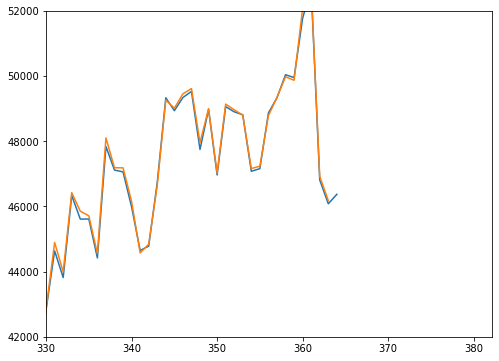

In [31]:
# plt.plot(predictions[0])
plt.figure(figsize=(8,6))
plt.plot(df_all["Value"][-len(predictions[0]) - 1:].values)
plt.plot((1 + predictions[0]) * df_all["Value"][-len(predictions[0]) - 1: -1].values)
plt.xlim(left=330)
plt.ylim(42000, 52000)
# df_tmp = df_test.iloc[SEQUENCE_LENGTH:].copy()
# df_tmp["Bitcoin % Change (Predicted)"] = predictions[0]
# df_tmp["Value (Predicted)"] = (1 + predictions[0]) * df_all["Value"][-len(predictions[0]) - 1: -1].values
# df_tmp["Value"] = df_all["Value"][-len(predictions[0]):]
# df_tmp

In [22]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()

predictions = []

with torch.no_grad():

    for X, y in train_loader:

        model.hidden_cell = (torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda(
        ), torch.zeros(2, X.shape[0], model.hidden_layer_size).cuda())

        predictions.append(model(X))


In [23]:
predictions = torch.transpose(torch.vstack(predictions), 0, 1).cpu()


In [1]:
plt.plot(df_all["Value"][SEQUENCE_LENGTH:len(
    predictions[0]) + SEQUENCE_LENGTH].values)
plt.plot((1 + predictions[0]) * df_all["Value"]
         [SEQUENCE_LENGTH - 1: SEQUENCE_LENGTH + len(predictions[0]) - 1].values)

plt.xlim(-1, 40)
plt.ylim(575, 800)


NameError: name 'plt' is not defined